In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


from net import Net

In [2]:
mu = 0.1307
sigma = 0.3081

train = pd.read_csv('datasets/mnist_train_modified.csv')
test = pd.read_csv('datasets/mnist_test_modified.csv')
X_train = train.loc[:,train.columns != "label"].values/255   #Normalizing the values
X_train = (X_train - mu) / sigma
X_train = X_train.reshape(-1, 1, 28, 28)
Y_train = train.label.values
X_test = test.loc[:,test.columns != "label"].values/255   #Normalizing the values
X_test = (X_test - mu) / sigma
X_test = X_test.reshape(-1, 1, 28, 28)
Y_test = test.label.values

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
Y_train = torch.from_numpy(Y_train)
Y_test = torch.from_numpy(Y_test)

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
test_set = torch.utils.data.TensorDataset(X_test, Y_test)

# train_set = torchvision.datasets.MNIST('/datasets/', 
#                                           train=True, 
#                                           download=True, 
#                                           transform=transforms.Compose([transforms.ToTensor(),
#                                                                        transforms.Normalize((0.1307,), (0.3081,))]))
# test_set = torchvision.datasets.MNIST('/datasets/', 
#                                          train=False, 
#                                          download=True, 
#                                          transform=transforms.Compose([transforms.ToTensor(), 
#                                                                       transforms.Normalize((0.1307,), (0.3081,))]))

In [3]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=X_test.shape[0], shuffle=True)

In [4]:
test_loader = enumerate(test_loader)
batch_idx, (X_test, Y_test) = next(test_loader) 

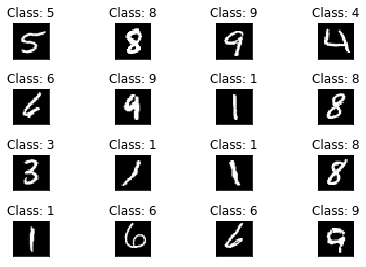

In [5]:
fig = plt.figure()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    i += 8900
    plt.tight_layout()
    plt.title(f'Class: {Y_test[i] + 1}')
    plt.imshow(X_test[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [6]:
n_epochs = 3
lr = 0.001
net = Net()
net = net.float()
optimizer = optim.Adam(net.parameters(), lr=lr)

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.float())
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data.float())
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=X_test.shape[0], shuffle=True)

for epoch in range(1, n_epochs + 1): 
    train(net, train_loader, optimizer, epoch)
    test(net, test_loader)

Train Epoch: 1 [0/54666 (0%)]	Loss: 2.223808
Train Epoch: 1 [6400/54666 (12%)]	Loss: 0.223557
Train Epoch: 1 [12800/54666 (23%)]	Loss: 0.565111
Train Epoch: 1 [19200/54666 (35%)]	Loss: 0.186620
Train Epoch: 1 [25600/54666 (47%)]	Loss: 0.181174
Train Epoch: 1 [32000/54666 (58%)]	Loss: 0.163006
Train Epoch: 1 [38400/54666 (70%)]	Loss: 0.148038
Train Epoch: 1 [44800/54666 (82%)]	Loss: 0.038697
Train Epoch: 1 [51200/54666 (94%)]	Loss: 0.159636

Test set: Average loss: 0.0490, Accuracy: 8970/9111 (98%)

Train Epoch: 2 [0/54666 (0%)]	Loss: 0.014213
Train Epoch: 2 [6400/54666 (12%)]	Loss: 0.055411
Train Epoch: 2 [12800/54666 (23%)]	Loss: 0.064170
Train Epoch: 2 [19200/54666 (35%)]	Loss: 0.097541
Train Epoch: 2 [25600/54666 (47%)]	Loss: 0.045213
Train Epoch: 2 [32000/54666 (58%)]	Loss: 0.105843
Train Epoch: 2 [38400/54666 (70%)]	Loss: 0.035131
Train Epoch: 2 [44800/54666 (82%)]	Loss: 0.005350
Train Epoch: 2 [51200/54666 (94%)]	Loss: 0.115267

Test set: Average loss: 0.0422, Accuracy: 8990/9111

In [8]:
torch.save(net.state_dict(), "cnn.pt")